In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's CS2?")

[{'url': 'https://counterstrike.fandom.com/wiki/Counter-Strike_2',
  'content': 'Counter-Strike 2 (CS2) is a first-person shooter video game developed by Valve Corporation which is a part of the Counter-Strike series.'},
 {'url': 'https://www.counter-strike.net/cs2',
  'content': 'Counter-Strike 2 is the largest technical leap forward in Counter-Strike’s history, ensuring new features and updates for years to come. Counter-Strike 2 is a free upgrade to CS:GO. In Counter-Strike 2 smoke particles work with the unified lighting system allowing for more realistic light and color. Classic maps with solid foundations that players can use to evaluate gameplay changes from CS:GO to Counter-Strike 2. All of the visual effects have been updated in Counter-Strike 2. Leveraging the Source 2 Engine and modern hardware, environmental effects in Counter-Strike 2 feature improved visual fidelity and greater consistency. The UI in Counter-Strike 2 has gotten a complete overhaul, including fresh visual 

In [4]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [8]:
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.1,
    max_completion_tokens=None,
    timeout=None,
)

llm_with_tools = llm.bind_tools(tools)

In [9]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)


In [10]:
import json

from langchain_core.messages import ToolMessage

In [11]:
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


In [12]:
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [13]:
def route_tools(
    state: State,
):
    
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

In [14]:
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)

In [15]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()


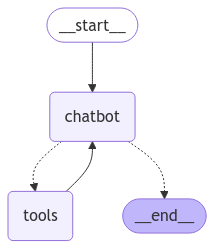

In [16]:
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import draw_mermaid_png

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [17]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [18]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"url": "https://www.aopanet.org/", "content": "AOPA Announces Significant Donation to the O&P Foundation Alexandria, VA (January 21, 2025) \u2013 The American Orthotic and Prosthetic Association (AOPA) is proud to announce a donation of $1 million over the next five years to the Orthotics and Prosthetics Foundation for Education and Research (O&P Foundation). The American Orthotics and Prosthetics Association (AOPA) Board of Directors is pleased to announce that Teri Kuffel, JD will serve as Interim Executive Director effective January 1. It is with mixed emotions that the American Orthotic and Prosthetic Association (AOPA) Board of Directors announce the departure of Eve Lee, MBA, CAE, who will be stepping down from her role as Executive Director, effective January 22, 2025. Search AOPA Members"}, {"url": "https://www.aopa.org/", "content": "Embark on your next aviation adventure: Explore exciting destinations, read inspiring travel stories, plan your trip wit